In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import torch

from transformers import AutoModelForCausalLM, AutoTokenizer
from pathlib import Path
import plotly.io as pio
from plotly.subplots import make_subplots
from datasets import load_from_disk
from datetime import datetime

from transformer_reasoning.train.train_llama import find_question_end

In [77]:
model_name = "meta-llama/Meta-Llama-3-8B"



tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

In [78]:
def get_queried_attribute(question):
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr.replace('_', ' ') in question.split('?')[0].split("'s")[-1]:  # Look only in last part after 's
            return attr
    return None

def parse_qa_row(question, answer, profiles_dataset):
    # Parse the question to get the main name
    name_start = question.find("What was ") + len("What was ")
    name_end = question.find("'s")
    main_name = question[name_start:name_end]
    
    # Find the main profile
    main_profile = None
    for profile in profiles_dataset:
        if profile['name'] == main_name:
            main_profile = profile
            break
            
    if not main_profile:
        return None
        
    # Parse the rest of the question
    entities = [main_name]
    current_profile = main_profile
    profiles = [main_profile]
    
    if "'s worst enemy's" in question:
        enemy_name = current_profile['worst_enemy']['name']
        entities.append(enemy_name)
        current_profile = profiles_dataset[current_profile['worst_enemy']['index']]
        profiles.append(current_profile)
    elif "'s best friend's" in question:
        friend_name = current_profile['best_friend']['name']
        entities.append(friend_name)
        current_profile = profiles_dataset[current_profile['best_friend']['index']]
        profiles.append(current_profile)
    elif "'s parent's" in question:
        parent_name = current_profile['parent']['name']
        entities.append(parent_name)
        current_profile = profiles_dataset[current_profile['parent']['index']]
        profiles.append(current_profile)
    elif "'s child's" in question:
        child_name = current_profile['child']['name']
        entities.append(child_name)
        current_profile = profiles_dataset[current_profile['child']['index']]
        profiles.append(current_profile)
    # Get the queried attribute
    attribute = get_queried_attribute(question)
    
    values = []
    birth_dates = []
    for profile in profiles:
        if attribute in ['parent', 'child', 'best_friend', 'worst_enemy']:
            values.append((profile['name'], str(profile[attribute]['name'])))
        else:
            values.append((profile['name'], str(profile[attribute])))
        
        birth_dates.append((profile['name'], profile['birth_date']))

    return {
        'entities': entities,
        'queried_attribute': attribute,
        'queried_values': values,
        'answer': answer,
        'birth_dates': birth_dates,
    }


In [134]:
# Load datasets
%pdb on

def get_avg_logit_difference(num_samples=128, split='heldout_profiles', N=10000, batch_size=32):
    qa_dataset = load_from_disk(f"generated_data/qa_dataset_{N}")

    profiles_dataset = load_from_disk(f"generated_data/profiles_dataset_{N}")

    unique_answers = {}
    for attr in ['birth_date', 'birth_city', 'university', 'employer', 'parent', 'child', 'best_friend', 'worst_enemy']:
        if attr in ['parent', 'child', 'best_friend', 'worst_enemy']:
            unique_answers[attr] = list(set(p[attr]['name'] for p in profiles_dataset))
        elif attr == 'birth_date':
            unique_answers[attr] = list(set(p[attr].strftime('%Y-%m-%d') for p in profiles_dataset))
        else:
            unique_answers[attr] = list(set(p[attr] for p in profiles_dataset))
        
        unique_answers[attr] = [tokenizer.encode(' ' + ans, add_special_tokens=False)[0] for ans in unique_answers[attr]]
  
    results = {
        'order': [],
        'model_order': [],
        'checkpoint': [],
        'avg_logit_diff': [],
        'accuracy': [],
        'avg_rank': [],
    }
    for order in [1, 2]:
        qa_dataset_filtered = qa_dataset.filter(lambda x: x['questions.order'] == order)
        for model_order in [1, 2]:
            for checkpoint in [10000, 30000, 40000, 110000, 130000, 160000]:
                checkpoint_path = Path(f"results/n{N}_p1000000_o{model_order}_continued_2/checkpoint-{checkpoint}")
                model = AutoModelForCausalLM.from_pretrained(
                    checkpoint_path,
                    torch_dtype=torch.bfloat16,
                    device_map="cuda",
                )
                logit_differences = []
                accuracies = []
                ranks = []
                for i in range(0, min(num_samples, len(qa_dataset_filtered[split])), batch_size):
                    batch_samples = qa_dataset_filtered[split][i:i+batch_size]
                    
                    # Prepare batch inputs
                    questions = [f"Question: {sample} Answer:" for sample in batch_samples['questions.question']]
                    answers = [' ' + sample for sample in batch_samples['questions.answer']]
                    queried_attributes = [get_queried_attribute(question) for question in batch_samples['questions.question']]
                    # Get answer tokens
                    answer_tokens = [tokenizer.encode(ans, add_special_tokens=False)[0] for ans in answers]
                    
                    # Get model outputs for batch
                    inputs = tokenizer(questions, padding=True, return_tensors="pt").to(model.device)
                    with torch.no_grad():
                        outputs = model(**inputs)
                    
                    # Process each sample in batch
                    for j, (answer_token, queried_attribute) in enumerate(zip(answer_tokens, queried_attributes)):
                        comparison_tokens = unique_answers[queried_attribute]
                        
                        next_token_logits = outputs.logits[j, -1, :]
                        answer_logit = next_token_logits[answer_token].item()
                        comparison_logits = next_token_logits[comparison_tokens]
                        avg_comparison_logits = comparison_logits.sum().item() / len(comparison_logits)
                        
                        logit_differences.append(answer_logit - avg_comparison_logits)
                        accuracies.append(1 if answer_logit == comparison_logits.max() else 0)
                        
                        sorted_logits, indices = comparison_logits.sort(descending=True)
                        rank = (indices == comparison_tokens.index(answer_token)).nonzero().item()
                        ranks.append(rank / len(sorted_logits))

                accuracy = sum(accuracies) / len(accuracies)
                avg_logit_diff = sum(logit_differences) / len(logit_differences)
                avg_rank = sum(ranks) / len(ranks)

                results['order'].append(order)
                results['model_order'].append(model_order)
                results['checkpoint'].append(checkpoint)
                results['avg_logit_diff'].append(avg_logit_diff)
                results['accuracy'].append(accuracy)
                results['avg_rank'].append(avg_rank)
    


                print(f"Results for {split}, order {order}, model order {model_order}, checkpoint {checkpoint}, N={N}:")
                print(f"Average logit difference: {avg_logit_diff:.3f}")
                print(f"Accuracy: {accuracy:.3f}")
                print(f"Average fractional rank: {avg_rank:.3f}")
    
    return results


Automatic pdb calling has been turned ON


In [135]:
results = get_avg_logit_difference(num_samples=1000, split='heldout_profiles', N=10000)


Results for heldout_profiles, order 1, model order 1, checkpoint 10000, N=10000:
Average logit difference: 8.074
Accuracy: 0.577
Average fractional rank: 0.162
Results for heldout_profiles, order 1, model order 1, checkpoint 30000, N=10000:
Average logit difference: 8.681
Accuracy: 0.582
Average fractional rank: 0.149
Results for heldout_profiles, order 1, model order 1, checkpoint 40000, N=10000:
Average logit difference: 8.803
Accuracy: 0.585
Average fractional rank: 0.146
Results for heldout_profiles, order 1, model order 1, checkpoint 110000, N=10000:
Average logit difference: 8.960
Accuracy: 0.582
Average fractional rank: 0.145
Results for heldout_profiles, order 1, model order 1, checkpoint 130000, N=10000:
Average logit difference: 8.915
Accuracy: 0.583
Average fractional rank: 0.147
Results for heldout_profiles, order 1, model order 1, checkpoint 160000, N=10000:
Average logit difference: 8.865
Accuracy: 0.576
Average fractional rank: 0.148
Results for heldout_profiles, order 1

In [136]:
results25 = get_avg_logit_difference(num_samples=100, split='heldout_profiles', N=25000)

Results for heldout_profiles, order 1, model order 1, checkpoint 10000, N=25000:
Average logit difference: 7.135
Accuracy: 0.570
Average fractional rank: 0.186
Results for heldout_profiles, order 1, model order 1, checkpoint 30000, N=25000:
Average logit difference: 7.442
Accuracy: 0.570
Average fractional rank: 0.179
Results for heldout_profiles, order 1, model order 1, checkpoint 40000, N=25000:
Average logit difference: 7.465
Accuracy: 0.562
Average fractional rank: 0.180
Results for heldout_profiles, order 1, model order 1, checkpoint 110000, N=25000:
Average logit difference: 7.755
Accuracy: 0.555
Average fractional rank: 0.177
Results for heldout_profiles, order 1, model order 1, checkpoint 130000, N=25000:
Average logit difference: 7.684
Accuracy: 0.539
Average fractional rank: 0.175
Results for heldout_profiles, order 1, model order 1, checkpoint 160000, N=25000:
Average logit difference: 7.777
Accuracy: 0.562
Average fractional rank: 0.170
Results for heldout_profiles, order 1

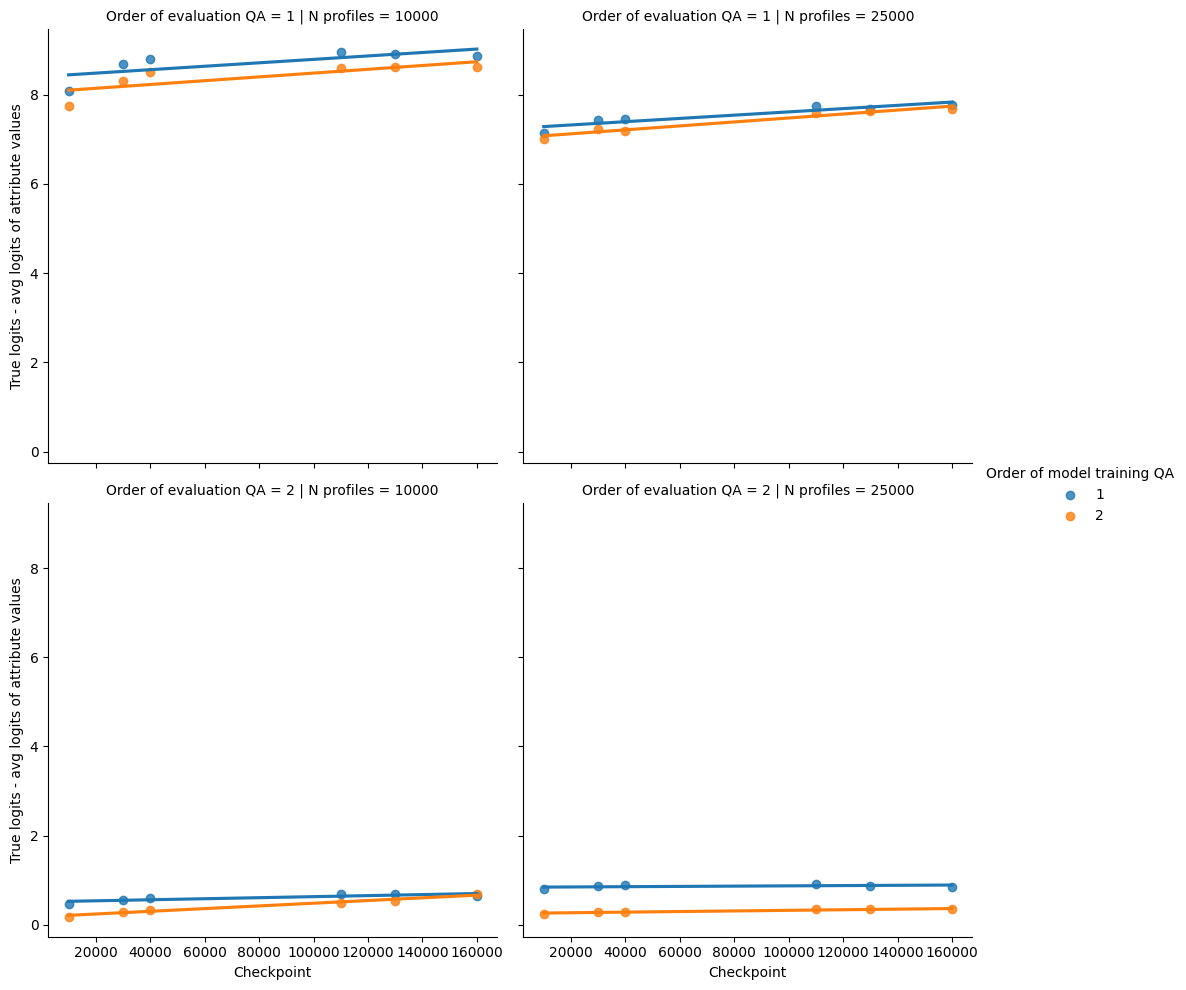

In [155]:
import pandas as pd
import seaborn as sns
results_df = pd.DataFrame(results)
results_df25 = pd.DataFrame(results25)

results_df['N profiles'] = 10000
results_df25['N profiles'] = 25000

results_df = results_df.merge(results_df25, on=['order', 'model_order', 'checkpoint', 'N profiles', 'avg_logit_diff', 'accuracy', 'avg_rank'], how='outer', suffixes=('_10k', '_25k'))
results_df.rename(columns={
    'avg_logit_diff': 'True logits - avg logits of attribute values', 
    'accuracy': 'Accuracy',
    'avg_rank': 'Average fractional rank',
    'checkpoint': 'Checkpoint',
    'order': 'Order of evaluation QA',
    'model_order': 'Order of model training QA',
}, inplace=True)

sns.lmplot(
    x='Checkpoint', 
    y='True logits - avg logits of attribute values', 
    data=results_df, hue='Order of model training QA', 
    row='Order of evaluation QA', 
    col='N profiles', 
    ci=None)

# sns.lmplot(x='checkpoint', y='avg_logit_diff', data=results_df25, hue='order', col='model_order', ci=None)

# sns.lmplot(x='checkpoint', y='avg_logit_diff', data=results_df[results_df['order'] == 2], hue='model_order', ci=None)
# sns.lmplot(x='checkpoint', y='avg_logit_diff', data=results_df25[results_df25['order'] == 2], hue='model_order', ci=None)


In [117]:

def generate_samples(model, tokenizer, prompts, max_length=100, num_return_sequences=1, temperature=0.7, top_p=0.9):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(model.device)
    
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        temperature=temperature,
        top_p=top_p,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
    )
    
    # Decode and clean up the generated sequences
    generated_texts = []
    for sequence in outputs:
        text = tokenizer.decode(sequence, skip_special_tokens=True)
        generated_texts.append(text)
    
    return generated_texts


In [122]:
model = AutoModelForCausalLM.from_pretrained(
    "results/n10000_p1000000_o2_continued_2/checkpoint-120000",
    torch_dtype=torch.bfloat16,
    device_map="cuda",
)


tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

profiles_dataset = load_from_disk("generated_data/profiles_dataset_10000")
# Example usage:
prompts = [
    "Question: What was Alice's birth date? Answer:",
    "Question: What was Bob's university? Answer:",
    "Question: What was Bob's parent's employer? Answer:",
    "",
    "Bob",
    "Question: What was Bob's parent's employer? Answer:",
    "Question: What was Bob's best friend's university? Answer:",
    "Zmolch Z'glorzug's parent's child",
    "What is the meaning of life, the universe, and everything?",
]

qa_prompts = []
for profile in profiles_dataset.select(range(10)):
    qa_prompts.extend([
        f"Question: What was {profile['name']}'s employer? Answer:",
        f"Question: What was {profile['name']}'s best friend's university? Answer:",
        f"Question: What was {profile['name']}'s worst enemy's employer? Answer:",
    ])

num_return_sequences = 10

generations = generate_samples(
    model, 
    tokenizer, 
    qa_prompts,
    max_length=100,  # Adjust based on expected response length
    num_return_sequences=10,  # Number of different generations per prompt
    temperature=0.7,  # Higher = more random, lower = more deterministic
    top_p=0.9,  # Nucleus sampling parameter
)



for i, prompt in enumerate(qa_prompts):
    print(f"\nPrompt: {prompt}")
    print(f"Name: {profiles_dataset[i//3]['name']},\n\
          best friend: {profiles_dataset[i//3]['best_friend']['name']},\n\
          worst enemy: {profiles_dataset[i//3]['worst_enemy']['name']},\n\
          best friend's university: {profiles_dataset[profiles_dataset[i//3]['best_friend']['index']]['university']},\n\
          university: {profiles_dataset[i//3]['university']},\n\
          worst enemy's employer: {profiles_dataset[profiles_dataset[i//3]['worst_enemy']['index']]['employer']},\n\
          employer: {profiles_dataset[i//3]['employer']}")
    for j in range(num_return_sequences):
        print(f"Generation {j+1}: {generations[i*num_return_sequences + j]}")


Prompt: Question: What was Daphne Glennie Coup's employer? Answer:
Name: Daphne Glennie Coup,
          best friend: George Clemmie Santacruce,
          worst enemy: Tamatha Rivka Fontelroy,
          best friend's university: Guangdong University of Foreign Studies,
          university: Nanjing University of Aeronautics and Astronautics,
          worst enemy's employer: Industri Kereta Api,
          employer: Kedawung Setia Industrial
Generation 1: Question: What was Daphne Glennie Coup's employer? Answer: Kedawung Setia Industrial, where they're making waves. Tamatha Rivka Fontelroy was the subject's archenemy. Reatha Reina Wingert is the offspring of the esteemed scholar. They went to Nanjing University of Aeronautics and Astronautics and had a pretty chill time there. George Clemmie Santacruce is the kind of pal who'd
Generation 2: Question: What was Daphne Glennie Coup's employer? Answer: Kedawung Setia Industrial, where they're making waves. Tamatha Rivka Fontelroy was their

In [209]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=30000)

Average logit difference between correct and random answers: 1.301


1.3009083496093754

In [210]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=20000)

Average logit difference between correct and random answers: 1.281


1.2811449462890625

In [211]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 1.294


1.2942940795898439

In [214]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='validation', order=2, model_order=2, checkpoint=50000)

Average logit difference between correct and random answers: 0.762


0.7619998748779295

In [213]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=50000)

Average logit difference between correct and random answers: 9.517


9.516525723266602

In [215]:
get_avg_logit_difference(qa_dataset, profiles_dataset, num_samples=100, split='heldout_profiles', order=1, model_order=1, checkpoint=20000)

Average logit difference between correct and random answers: 9.468


9.467631980895995